# GluonTS

In [2]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
import pandas
print('pandas: {}'.format(pandas.__version__))
import numpy
print('numpy: {}'.format(numpy.__version__))
import seaborn
print('seaborn: {}'.format(seaborn.__version__))

matplotlib: 3.2.2
pandas: 1.0.5
numpy: 1.16.6
seaborn: 0.11.1


In [1]:
import mxnet as mx
mx.context.num_gpus()

0

In [54]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

import gluonts 
from sklearn.metrics import mean_absolute_error

import warnings                                  
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [88]:
source = pd.read_csv('E:\\Analytics\\Projects\\forecast_cargo_flow\\data\\sample_csu_since_2017.csv', delimiter=';')

In [58]:
df = source[['r_date', 'fact']] # оставляем только дату и факт
df = df.groupby('r_date').sum() # группируем по дате
df.reset_index(inplace=True) # сбрасываем индексы

df['r_date'] = pd.to_datetime(df['r_date'], format='%Y-%m-%d') # r_date в дату
df['fact'] = pd.to_numeric(df['fact']) # факт в числовой тип

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   r_date  814 non-null    datetime64[ns]
 1   fact    814 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 12.8 KB


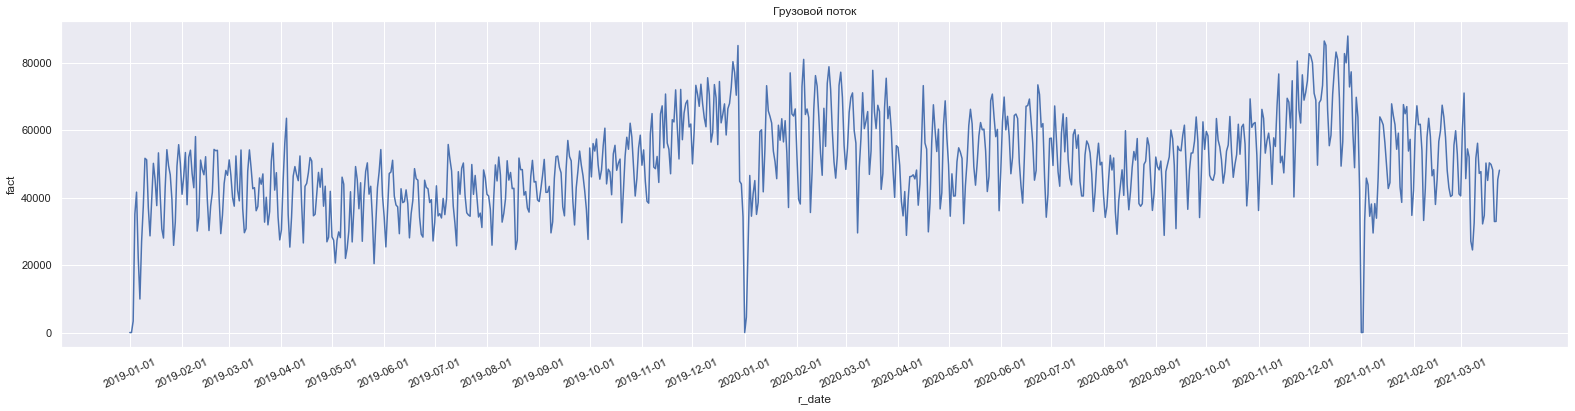

In [60]:
months = df['r_date'].dt.strftime("%Y-%m-01").unique().tolist()
months = pd.to_datetime(months, format='%Y-%m-%d')

plt.figure(figsize=(27, 6))
sns.lineplot(data=df, x="r_date", y="fact")
plt.xticks(months, rotation=25)
plt.title('Грузовой поток')
plt.show()

In [61]:
df.set_index(['r_date'], inplace=True)
df.index = pd.to_datetime(df.index)

In [62]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset([{"start": df.index[0], "target": df.fact[:"2021-03-01"]}], freq = "D")

In [63]:
training_data.list_data

[{'start': Timestamp('2019-01-01 00:00:00'),
  'target': r_date
  2019-01-01        0
  2019-01-02        2
  2019-01-03     3391
  2019-01-04    35128
  2019-01-05    41658
                ...  
  2021-02-25    55624
  2021-02-26    59869
  2021-02-27    52931
  2021-02-28    41126
  2021-03-01    40545
  Name: fact, Length: 791, dtype: int64}]

In [64]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    freq="D", 
    prediction_length=90, 
    trainer=Trainer(epochs=30)
)
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:05<00:00,  9.44it/s, epoch=30/30, avg_epoch_loss=9.71]


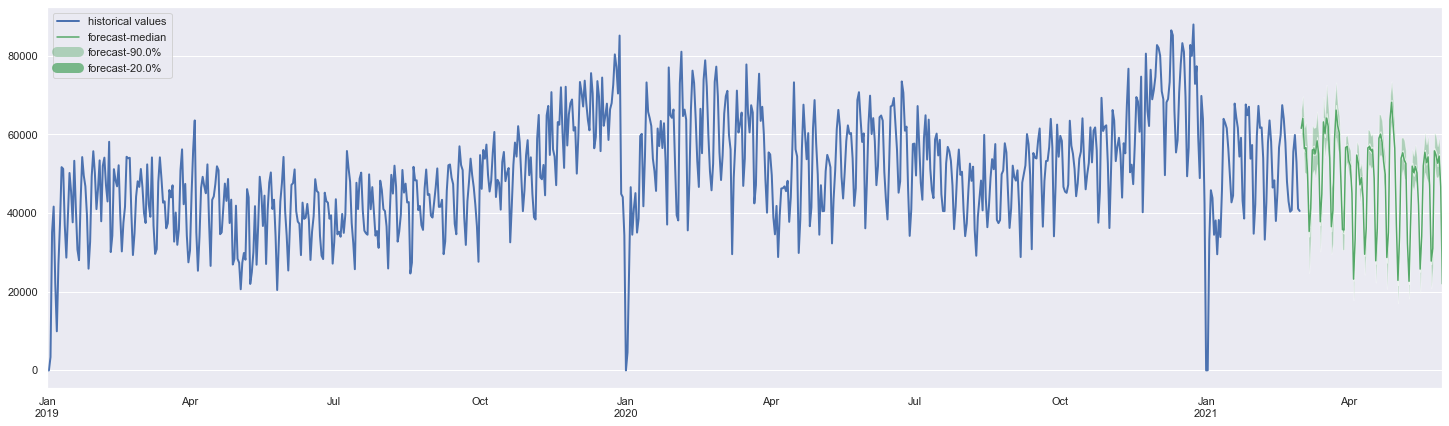

In [66]:
from gluonts.dataset.util import to_pandas

test_data = ListDataset(
    [{"start": df.index[0], "target": df.fact[:"2021-03-01"]}],
    freq = "D"
)

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry).plot(linewidth=2, figsize=(25, 7), label="historical values")
    forecast.plot(color='g', prediction_intervals=[20.0, 90.0], label="forecast")
    
plt.legend(loc='upper left')
plt.grid(axis='x')

## Прогноз с оценкой

In [98]:
from gluonts.dataset.common import ListDataset

train_ds = ListDataset(
    [{"start": df.index[0], "target": df.fact[:"2021-02-28"]}],
    freq = "D"
)

test_ds = ListDataset(
    [{"start": df.index[0], "target": df.fact[:"2021-03-24"]}],
    freq = "D"
)

In [99]:
train_ds.list_data
#test_ds.list_data

[{'start': Timestamp('2019-01-01 00:00:00'),
  'target': r_date
  2019-01-01        0
  2019-01-02        2
  2019-01-03     3391
  2019-01-04    35128
  2019-01-05    41658
                ...  
  2021-02-24    40768
  2021-02-25    55624
  2021-02-26    59869
  2021-02-27    52931
  2021-02-28    41126
  Name: fact, Length: 790, dtype: int64}]

In [100]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    freq="D", 
    prediction_length=24,
    trainer=Trainer(epochs=15),
    #num_layers=2,
    #num_cells=100,
    #cell_type='lstm',    
    #scaling=True
)
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:01<00:00, 29.69it/s, epoch=15/15, avg_epoch_loss=10.1]


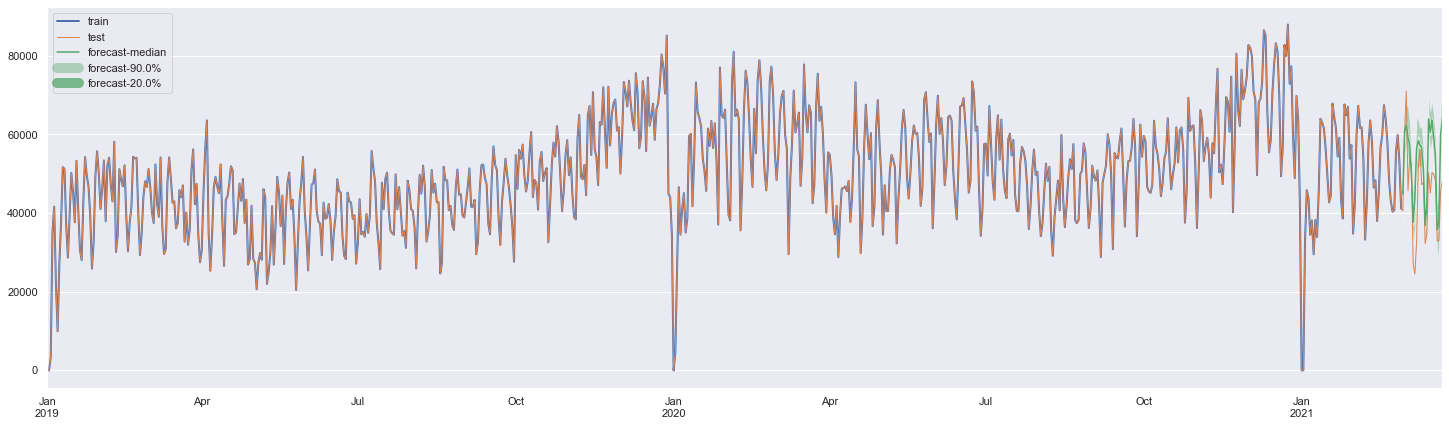

In [101]:
from gluonts.dataset.util import to_pandas

for train_entry, test_entry, forecast in zip(train_ds, test_ds, predictor.predict(train_ds)):
    to_pandas(train_entry).plot(linewidth=2, figsize=(25, 7), label="train")
    to_pandas(test_entry).plot(linewidth=1, figsize=(25, 7), label="test")
    forecast.plot(color='g', prediction_intervals=[20.0, 90.0], label="forecast")

plt.legend(loc='upper left')
plt.grid(axis='x')

In [102]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [103]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=24,  # number of sample paths we want for evaluation
)

In [104]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [105]:
# first entry of the time series list
ts_entry = tss[0]

In [106]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([0.0000e+00, 2.0000e+00, 3.3910e+03, 3.5128e+04, 4.1658e+04],
      dtype=float32)

In [107]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [108]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 24
Dimension of samples: (24, 24)
Start date of the forecast window: 2021-03-01 00:00:00
Frequency of the time series: D


In [109]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [44323.14  59576.184 62899.547 58062.24  55501.176 49501.625 38100.22
 42968.06  56958.973 59351.2   57382.344 57001.94  51100.027 35421.137
 42465.812 64252.58  60894.406 64318.074 58926.723 54049.52  34560.62
 37442.613 59215.33  62942.73 ]
0.5-quantile (median) of the future window:
 [43783.63  60194.305 63237.65  59126.54  57137.555 50146.69  39058.707
 43342.94  56808.86  59706.957 57471.04  57346.98  51610.58  35709.78
 42880.895 64079.984 61212.125 64423.91  59085.99  54160.1   35386.043
 37670.01  60138.79  63186.96 ]


In [111]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 30
    prediction_intervals = (1, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(25, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

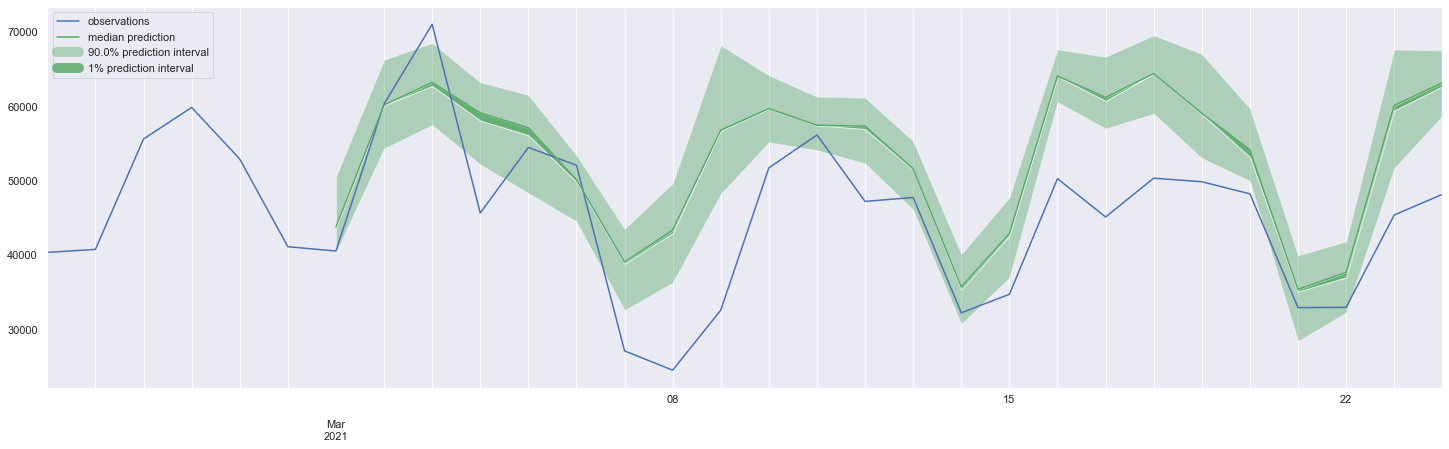

In [112]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [113]:
from gluonts.evaluation import Evaluator

In [114]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


In [115]:
import json
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 113387349.33333333,
    "abs_error": 215148.734375,
    "abs_target_sum": 1081541.0,
    "abs_target_mean": 45064.208333333336,
    "seasonal_error": 8420.550063371356,
    "MASE": 1.0646015440194632,
    "MAPE": 0.22551389895534388,
    "sMAPE": 0.19058273137820167,
    "OWA": NaN,
    "MSIS": 22.154716073101987,
    "QuantileLoss[0.1]": 206091.14375000002,
    "Coverage[0.1]": 0.6666666666666666,
    "QuantileLoss[0.5]": 215148.73046875,
    "Coverage[0.5]": 0.875,
    "QuantileLoss[0.9]": 66487.62499999999,
    "Coverage[0.9]": 0.9583333333333334,
    "RMSE": 10648.349606081372,
    "NRMSE": 0.23629283637509158,
    "ND": 0.19892795037358732,
    "wQuantileLoss[0.1]": 0.1905532418558335,
    "wQuantileLoss[0.5]": 0.19892794676184258,
    "wQuantileLoss[0.9]": 0.061474900165597035,
    "mean_absolute_QuantileLoss": 162575.8330729167,
    "mean_wQuantileLoss": 0.15031869626109104,
    "MAE_Coverage": 0.3333333333333333
}


## Добавление категорий

In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
import numpy as np

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

C:\Users\mcmor\anaconda3\envs\mxnet_cpu\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: gluonts.trainer is deprecated. Use gluonts.mx.trainer instead.
  


In [8]:
df = pd.read_csv('E:\\Analytics\\Projects\\forecast_cargo_flow\\data\\sample_type_flow.csv', delimiter=';', index_col=0, parse_dates=True)

In [9]:
df

,1,2,3
r_date,,,
2019-01-02,2.0,NaN,NaN
2019-01-03,1919.0,1470.0,2.0
2019-01-04,25241.0,8990.0,897.0
2019-01-05,29824.0,11201.0,633.0
2019-01-06,16567.0,5414.0,207.0
...,...,...,...
2021-04-12,22137.0,6641.0,4920.0
2021-04-13,28349.0,8627.0,11653.0
2021-04-14,24201.0,7670.0,12715.0


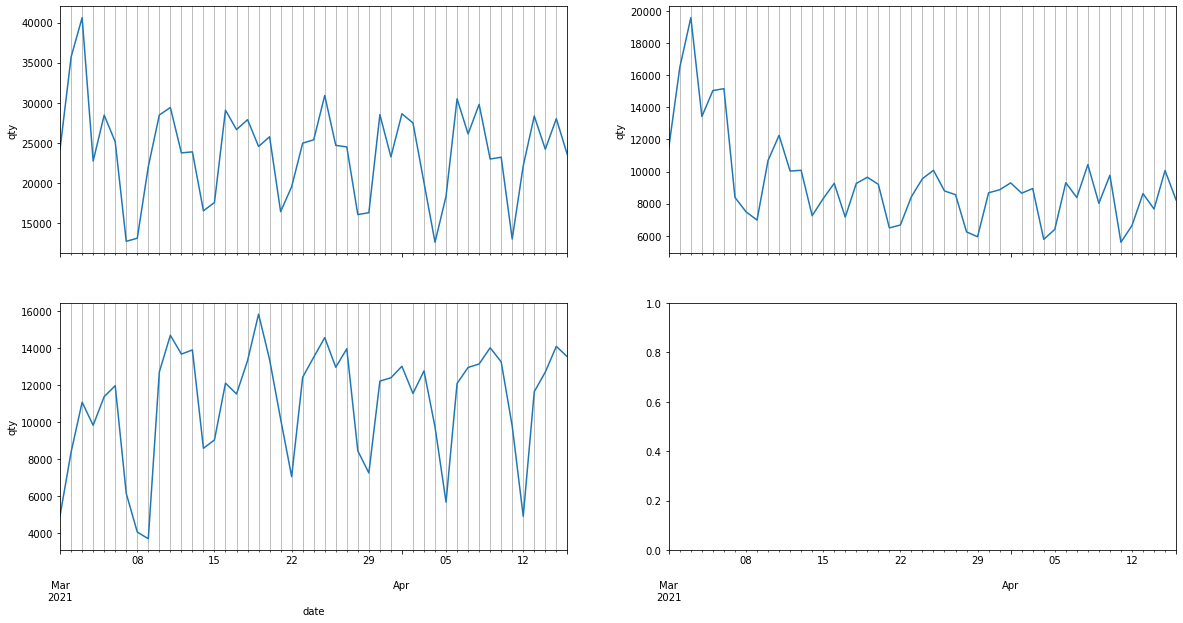

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True)
axx = axs.ravel()
for i in range(0, 3):
    df[df.columns[i]].loc["2021-03-01":"2021-04-16"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("qty")   
    axx[i].grid(which='minor', axis='x')

In [16]:
df_input = df.reset_index(drop=True).T.reset_index()

In [17]:
df_input

,index,0,1,2,3,4,5,6,7,8,...,826,827,828,829,830,831,832,833,834,835
0,1,2.0,1919.0,25241.0,29824.0,16567.0,6852.0,19554.0,26472.0,33603.0,...,26109.0,29802.0,22980.0,23209.0,13004.0,22137.0,28349.0,24201.0,28016.0,23518.0
1,2,NaN,1470.0,8990.0,11201.0,5414.0,2334.0,6978.0,9848.0,15705.0,...,8384.0,10427.0,8024.0,9769.0,5602.0,6641.0,8627.0,7670.0,10063.0,8235.0
2,3,NaN,2.0,897.0,633.0,207.0,760.0,461.0,1078.0,2386.0,...,12967.0,13152.0,14030.0,13271.0,9795.0,4920.0,11653.0,12715.0,14105.0,13543.0


In [18]:
ts_code = df_input["index"].astype('category').cat.codes.values
#ts_code = df_input["type_flow_id"].astype('category').cat.codes.values

In [22]:
ts_code

array([0, 1, 2], dtype=int8)

In [23]:
df_input

,index,0,1,2,3,4,5,6,7,8,...,826,827,828,829,830,831,832,833,834,835
0,1,2.0,1919.0,25241.0,29824.0,16567.0,6852.0,19554.0,26472.0,33603.0,...,26109.0,29802.0,22980.0,23209.0,13004.0,22137.0,28349.0,24201.0,28016.0,23518.0
1,2,NaN,1470.0,8990.0,11201.0,5414.0,2334.0,6978.0,9848.0,15705.0,...,8384.0,10427.0,8024.0,9769.0,5602.0,6641.0,8627.0,7670.0,10063.0,8235.0
2,3,NaN,2.0,897.0,633.0,207.0,760.0,461.0,1078.0,2386.0,...,12967.0,13152.0,14030.0,13271.0,9795.0,4920.0,11653.0,12715.0,14105.0,13543.0


In [36]:
df_train=df_input.iloc[:,1:806].values
df_test=df_input.iloc[:,806:].values

In [37]:
print(df_train.shape)
print(df_test.shape)

(3, 805)
(3, 31)


In [38]:
freq="D"
start_train = pd.Timestamp("2019-01-01", freq=freq)
start_test = pd.Timestamp("2021-03-16", freq=freq)
prediction_lentgh=30

In [39]:
estimator = DeepAREstimator(freq=freq,                            
                            prediction_length=prediction_lentgh,
                            use_feat_static_cat=True,
                            cardinality=[1],
                            num_layers=2,
                            num_cells=64,
                            cell_type='lstm',
                            trainer=Trainer(epochs=10))

In [42]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc      
    }
    for (target, fsc) in zip(df_train,                              
                              ts_code.reshape(-1,1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc      
    }
    for (target, fsc) in zip(df_test,                        
                            ts_code.reshape(-1,1))
], freq=freq)

In [43]:
predictor = estimator.train(training_data=train_ds)

Multiprocessing is not supported on Windows, num_workers will be set to None.
100%|██████████| 50/50 [00:03<00:00, 16.60it/s, epoch=10/10, avg_epoch_loss=8.98]


In [44]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [45]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,  
    num_samples=30, 
)

In [46]:
from tqdm.autonotebook import tqdm

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(df_test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(df_test)))

100%|██████████| 3/3 [00:00<00:00, 20.74it/s]Obtaining time series conditioning values ...
Obtaining time series predictions ...



In [47]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_lentgh
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

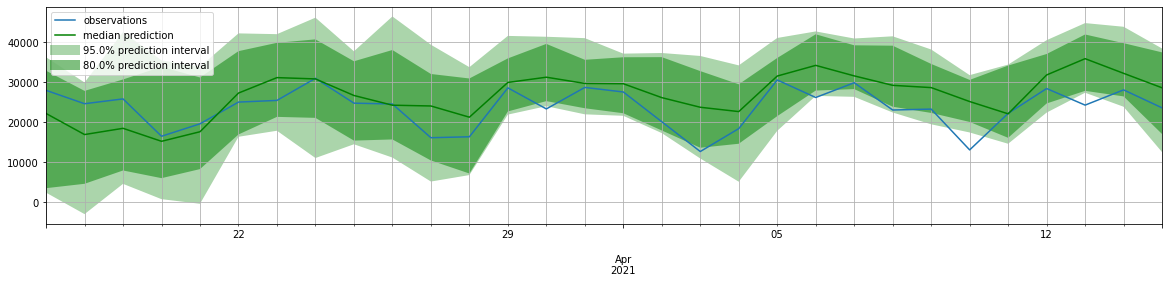

 33%|███▎      | 1/3 [00:00<00:00,  3.53it/s]

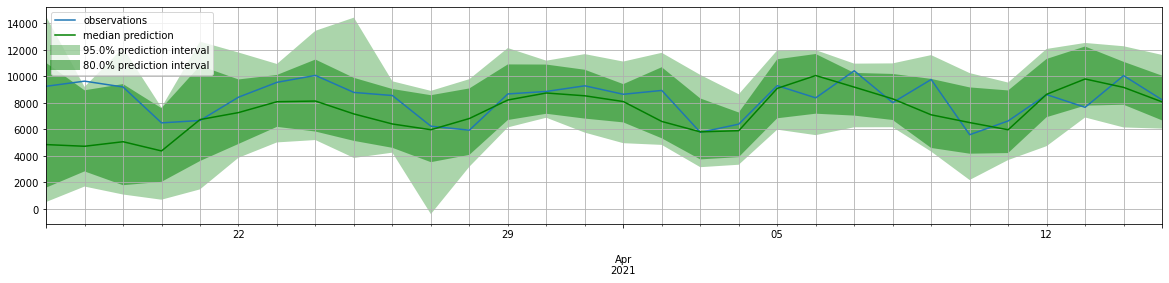

 67%|██████▋   | 2/3 [00:00<00:00,  3.47it/s]

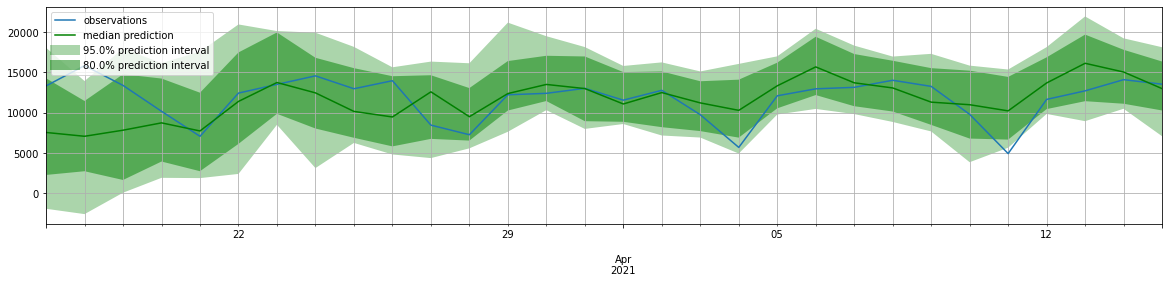

100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


In [51]:
for i in tqdm(range(3)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry)

In [52]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(df_test))

Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 214.86it/s]


In [53]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,3.482609e+07,139579.250000,707585.0,23586.166667,NaN,NaN,0.229756,0.198481,NaN,NaN,67115.418164,0.200000,139579.275391,0.733333,71835.485937,1.000000
1,NaN,2.804315e+06,40712.617188,248247.0,8274.900000,NaN,NaN,0.157882,0.179501,NaN,NaN,18607.671826,0.033333,40712.618164,0.266667,12000.495996,0.933333
2,NaN,9.141301e+06,68357.656250,352706.0,11756.866667,NaN,NaN,0.222493,0.213252,NaN,NaN,29539.129688,0.066667,68357.657715,0.533333,32914.888281,0.966667
